In [1]:
import requests, json, matplotlib.pyplot as plt, plotly.express as px, pandas as pd, IPython.core.display as ip
from datetime import datetime
from IPython.core.debugger import set_trace
import matplotlib.dates as mdates
mostRecentSurvey = '2020'
surveyURIs = {'2019':'https://five.epicollect.net/api/export/entries/salmon-survey-2019?form_ref=397fba6ecc674b74836efc190840c42d_5d6f454667a28',
              '2020':'https://five.epicollect.net/api/export/entries/salmon-survey-2020?form_ref=f550ab6c4dab44f49bcc33b7c1904be9_5d6f454667a28',
              '2021':'https://five.epicollect.net/api/export/entries/salmon-survey-2021?form_ref=ad5ffedf0a3246a18934e6ec36ed9569_5d6f454667a28'}
salmonURIs = {'2019':'https://five.epicollect.net/api/export/entries/salmon-survey-2019?form_ref=397fba6ecc674b74836efc190840c42d_5d6f509867795',
              '2020':'https://five.epicollect.net/api/export/entries/salmon-survey-2020?form_ref=f550ab6c4dab44f49bcc33b7c1904be9_5d6f509867795',
              '2021':'https://five.epicollect.net/api/export/entries/salmon-survey-2021?form_ref=ad5ffedf0a3246a18934e6ec36ed9569_5d6f509867795'}
        
def getEntries(uri):
    request = requests.get(url = uri)
    df = pd.DataFrame(pd.json_normalize(request.json()['data']['entries']))
    while request.json()['links']['next'] is not None:
        nextURL = request.json()['links']['next']
        request = requests.get(url = nextURL)
        df = df.append(pd.json_normalize(request.json()['data']['entries']))
    return df

def filterSalmonDf(salmonDf, *filters):
    for filter in filters:
        field, value = filter
        salmonDf = salmonDf.loc[(salmonDf[field] == value)]
    return salmonDf
    
def addStats(survey, salmonDf):
    surveyUUID = survey['ec5_uuid']
    todaySalmonDf = salmonDf[salmonDf['ec5_parent_uuid'] == surveyUUID]
    deadChum = filterSalmonDf(todaySalmonDf, ('12_Species', 'Chum'), ('16_Status', 'Dead')).shape[0]
    deadCoho = filterSalmonDf(todaySalmonDf, ('12_Species', 'Coho'), ('16_Status', 'Dead')).shape[0]
    liveChum = filterSalmonDf(todaySalmonDf, ('12_Species', 'Chum'), ('16_Status', 'Live')).shape[0]
    liveCoho = filterSalmonDf(todaySalmonDf, ('12_Species', 'Coho'), ('16_Status', 'Live')).shape[0]
    remnant = filterSalmonDf(todaySalmonDf, ('16_Status', 'Remnant')).shape[0]
    cutthroat = filterSalmonDf(todaySalmonDf, ('12_Species', 'Cutthroat')).shape[0]
    totalDead = todaySalmonDf.loc[(todaySalmonDf['16_Status'] == 'Dead')].shape[0]
    totalLiveSalmon = liveChum + liveCoho
    total = (todaySalmonDf.shape[0])
    return pd.Series({'Survey Date': datetime.strptime(survey['1_Survey_Date'], '%m/%d/%Y').date(), 'Dead Chum': deadChum, 'Dead Coho': deadCoho, 'Live Chum': liveChum, 'Live Coho': liveCoho, 'Total Dead': totalDead, 'Total Live Salmon': totalLiveSalmon, 'Total': total, 'Remnant': remnant, 'Cutthroat': cutthroat})

salmonDf = getEntries(salmonURIs.get(mostRecentSurvey))
surveyDf = getEntries(surveyURIs.get(mostRecentSurvey))
statsDf = surveyDf.apply(addStats, axis=1, args=[salmonDf]).groupby(['Survey Date']).sum().reset_index()
columnOrder =  ['Survey Date', 'Total', 'Total Live Salmon', 'Total Dead', 'Live Chum', 'Live Coho', 'Dead Chum', 'Dead Coho', 'Remnant', 'Cutthroat']
statsDf = statsDf.sort_values(by=['Survey Date'])[columnOrder]
kwargs = {'Dead to Date' : statsDf['Total Dead'].cumsum(), 'Dead Chum to Date' : statsDf['Dead Chum'].cumsum(), 'Dead Coho to Date' : statsDf['Dead Coho'].cumsum()}
statsDf = statsDf.assign(**kwargs)
surveyDfs = {};
salmonDfs = {};
statsDfs = {};
for year in surveyURIs:
    surveyDfs[year] = getEntries(surveyURIs[year])
for year in salmonURIs:
    salmonDfs[year] = getEntries(salmonURIs[year])
for year in surveyDfs:
    if not salmonDfs[year].empty:
        statsDfs[year] = surveyDfs[year].apply(addStats, axis=1, args=[salmonDfs[year]]).groupby(['Survey Date']).sum().reset_index()
        statsDfs[year]['Survey Date'] = statsDfs[year]['Survey Date'].apply(lambda x: datetime.strptime(x.strftime("%m-%d"), "%m-%d"))

In [2]:
def displaySurveyStatsTable(statsDf):
    display(ip.HTML(statsDf[['Survey Date', 'Total', 'Total Live Salmon', 'Total Dead', 'Live Chum', 'Live Coho', 'Dead Chum', 'Dead Coho', 'Remnant', 'Cutthroat']].to_html()))

def printYearlyTotals(statsDf):
    max = (statsDf['Dead to Date']+statsDf['Total Live Salmon']).max()
    idxmax = (statsDf['Dead to Date']+statsDf['Total Live Salmon']).idxmax()
    print('Yearly salmon total is:', int(max))
    print('Yearly total of Chum is:', int((statsDf['Dead Chum to Date']+statsDf['Live Chum']).max()))
    print('Yearly total of Coho is:', int((statsDf['Dead Coho to Date']+statsDf['Live Coho']).max()))
    print('Calculated based on date:', statsDf.iloc[idxmax]['Survey Date'])
    print('Based on total dead count:', int(statsDf.iloc[idxmax]['Dead to Date']), '|', 'plus total live count:', int(statsDf.iloc[idxmax]['Total Live Salmon']))
    
displaySurveyStatsTable(statsDf)
printYearlyTotals(statsDf)

,Survey Date,Total,Total Live Salmon,Total Dead,Live Chum,Live Coho,Dead Chum,Dead Coho,Remnant,Cutthroat
0,2020-10-15,2,0,1,0,0,0,1,0,0
1,2020-10-28,5,2,3,2,0,3,0,0,0
2,2020-10-29,4,4,0,4,0,0,0,0,0
3,2020-10-31,13,8,2,8,0,1,1,0,3
4,2020-11-04,36,28,5,28,0,2,3,0,3
5,2020-11-07,46,39,2,39,0,2,0,3,2
6,2020-11-11,63,41,18,40,1,17,1,3,0
7,2020-11-14,95,77,16,76,1,12,4,0,0
8,2020-11-18,108,75,12,75,0,11,1,3,0
9,2020-11-21,105,71,34,71,0,34,0,0,0


Yearly salmon total is: 201
Yearly total of Chum is: 190
Yearly total of Coho is: 11
Calculated based on date: 2020-12-02
Based on total dead count: 197 | plus total live count: 4


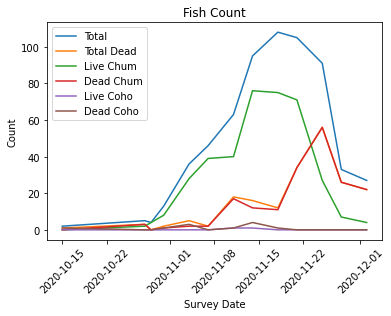

In [3]:
def displayCountPlot(statsDf):    
    plot = statsDf.plot(ylabel = 'Count', title = 'Fish Count', rot=45, y=['Total', 'Total Dead', 'Live Chum', 'Dead Chum', 'Live Coho', 'Dead Coho'], x='Survey Date')
displayCountPlot(statsDf)

In [6]:
def displayHeatMap(salmonDf):    
    fig = px.scatter_mapbox(salmonDf, lat='15_Location.latitude', lon='15_Location.longitude', color='15_Status',
                        center=dict(lat=47.71157, lon=-122.3759), zoom=15, hover_name = 'title', hover_data = ['15_Location.accuracy'],
                        mapbox_style='stamen-terrain', title='Fish Heat Map')
    fig.layout.coloraxis.showscale = False
    fig.show()
displayHeatMap(salmonDf)

ValueError: Value of 'color' is not the name of a column in 'data_frame'. Expected one of ['ec5_uuid', 'ec5_parent_uuid', 'created_at', 'uploaded_at', 'title', '11_Distance', '12_Species', '13_Life_Stage', '14_Stream', '16_Status', '18_Carcass_Location', '19_Adipose_Fin', '20_Predation', '21_Length_inches', '22_Width_inches', '23_Hours_since_death', '24_Spawned', '26_Redd', '28_Sex', '29_Notes', '15_Location.latitude', '15_Location.longitude', '15_Location.accuracy', '15_Location.UTM_Northing', '15_Location.UTM_Easting', '15_Location.UTM_Zone'] but received: 15_Status

In [ ]:
def displaySpawnedChart(salmonDf):
    pie, ax1 = plt.subplots()
    deadChumDf = filterSalmonDf(salmonDf, ('12_Species', 'Chum'), ('16_Status', 'Dead'))
    totalDeadChum = deadChumDf.shape[0]
    totalSpawnedChum = filterSalmonDf(deadChumDf, ('24_Spawned', 'Spawned')).shape[0]
    totalPartialSpawnedChum = filterSalmonDf(deadChumDf, ('24_Spawned', 'Partially spawned')).shape[0]
    totalUnspawnedChum = filterSalmonDf(deadChumDf, ('24_Spawned', 'Unspawned')).shape[0]
    totalUnknownSpawnedChum = filterSalmonDf(deadChumDf, ('24_Spawned', 'Unknown')).shape[0]
    spawnPercentages = [totalSpawnedChum/totalDeadChum*100, totalPartialSpawnedChum/totalDeadChum*100, totalUnspawnedChum/totalDeadChum*100, totalUnknownSpawnedChum/totalDeadChum*100]
    ax1.pie(spawnPercentages, labels=['Spawned', 'Partially Spawned', 'Unspawned', 'Unknown'], autopct='%1.1f%%')
    plt.title('Chum Spawn Percentage')
    plt.show()
displaySpawnedChart(salmonDf)

In [ ]:
def displayYearByYearCount(surveyURIs, salmonURIs):

#plot each series
    fig, ax = plt.subplots()
    plt.plot('Survey Date', 'Total', data=statsDfs['2019'], label="2019")
    plt.plot('Survey Date', 'Total', data=statsDfs['2020'], label="2020")
    plt.title('Count by time of year')
    plt.ylabel('Count')
    plt.xlabel('Survey Date')
    plt.xticks(rotation = 45)
    plt.legend()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

displayYearByYearCount(surveyURIs, salmonURIs)